# 1. Introduction/Business problem

This project is intended to study the most popular food venues of the city of Málaga (Spain) in order to decide which is the most frequent category, in which neighbourhoods are more likely to be found, and what are the prefered venues, according to their ratings.

Before choosing the problem above described, a little research has been conducted in order to decide the following items:

1. What kind of data can we retrieve from Foursquare and how many calls are we allowes to make to the API?
2. Since I live in Spain and I wanted to study a Spanish city, what are the main sources of open data available?
3. Is the available information enough to carry a study related to geolocated venues?

These questions will be answered in the following section.

The business problem that can be proposed is, given an investor interested in the restauration sector, what category of venue would be a good choice according to the methodology described below, and where to locate it. 

# 2. Data

## 2.1. Sources

In order to find out what are the prefered and most frequent food venues, and whether if there are any coincidences in the results, the following data has been used:

1. **Foursquare data retrieved from the "explore" endpoint.** We can get the following information:
    * Name of the venue.
    * Location (latitude and longitude).
    * Category.
    
There is a limit of 99.500 calls/day, which is a broad limit given the amount of data that is going to take to carry the project

2. **Foursquare data retrieved from the "details" endpoint.** The following information will be used:
    * Name of the venue.
    * Rating.
    * Count of likes.
    
In this case, the number of calls is much more limited, since a Personal account has only 500 calls/day.

3. **Geospatial data from the open data platform of the City Hall of Málaga.** The data is available if .shp format, wich contained the outline of the neighbourhoods of the city. With the help of the software QGIS, the centroids of the polygons have been calculated and their coordinates have been exported in .json format, in order to work with them easily with the json package. 

The reason why the city of Málaga was chosen is because it is one of the few Spanish cities that has an open data portal with geospatial data. Moreover, it is a very touristic city, which means that there is a great number of restauration venues that are likely to be rated by customers.

## 2.2. Methodology description

The process will consist of two parts with the following breakdown:

### Part I

1. Download and transformation of data from the City Hall of Málaga.
1. Download of data from Foursquare using the "explore" endpoint to obtain venues from the different neighbourhoods, filtering by category to get only food venues.
1. Obtention of the clusters in which the recommended venues can be put with the k-cluster method.
1. Discussion of the results obtained (relation between location of the neighbourhood and most frequent venues, most frequent clusters, etc)

### Part II

1. Restriction of the data obtained earlier to a maximum sample of 1.500 venues, setting a threshold of 20 venues/neighbourhood to drop neighbourhoods with low density of venues.
1. Download of data from Foursquare using the "details" endpoint to get the ratings and the count of likes associated to each venue.
1. Discussion of the prefered food venues according to the count of likes and the overall rating.

# 3. Methodology

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import requests
import folium
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

## Part I

---
As said in the Data section, the source of geospatial data has been transformed from shapefile polygons into a json file that contains the coordinates of the centroids of said polygons.

The following lines will get the json file from my github repository and turn them into a pandas dataframe

In [2]:
url='https://raw.githubusercontent.com/Fidaeic/IBM-capstone/master/Geospatial%20data/Centroides_Barrios_Malaga.json'
archivo = requests.get(url).json()

In [3]:
malaga_venues=archivo['features']
neighbourhood=pd.DataFrame()
for data in malaga_venues:
    id_neighbourhood  = data['properties']['NUMBARRIO'] 
    name_neighbourhood = data['properties']['NOMBARRIO']
        
    latlon = data['geometry']['coordinates']
    lat = latlon[1]
    lon = latlon[0]
    
    neighbourhood = neighbourhood.append({'Num_neighbourhood': id_neighbourhood,
                                          'Name': name_neighbourhood.lower().capitalize(),
                                          'Latitude': lat,
                                          'Longitude': lon}, ignore_index=True)
neighbourhood["Num_neighbourhood"]=neighbourhood["Num_neighbourhood"].map(lambda x: int(x))
neighbourhood.head()

,Latitude,Longitude,Name,Num_neighbourhood
0,36.651810,-4.514196,Cañada de ceuta,307
1,36.662529,-4.513345,San juan-el albaricocal,321
2,36.735346,-4.427377,La rosaleda,109
3,36.739066,-4.428161,503 viviendas,378
4,36.740912,-4.429205,La palmilla,107


---
As seen in week 3 of this module, we can use a function to retrieve information on venues from Foursquare. Particularly, this function will filter by category, adding the following string to the url: '4d4b7105d754a06374d81259'.

This category corresponds to **restaurants** and **cafés**.

In [4]:
def getNearbyFoodPlaces(names, latitudes, longitudes, radius=5000, LIMIT=10000):

    category='4d4b7105d754a06374d81259'
    VERSION = '20180605' # Foursquare API version
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT,
                category)
        try:
                
            results = requests.get(url).json()["response"]['groups'][0]['items']

            venues_list.append([(
                name, 
                lat, 
                lng,
                v['venue']['id'],
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighb', 
                      'Latitude', 
                      'Longitude',
                      'IdVenue',
                      'Venue', 
                      'Lat_venue', 
                      'Long_venue', 
                      'Category']
        
    
    return(nearby_venues)

The outcome of the previous function has been stored in my Github repository under the name 'mlg_food_venues.csv', so the API key is not displayed publicly.

In [14]:
mlg_food_venues=pd.read_csv('https://raw.githubusercontent.com/Fidaeic/IBM-capstone/master/Data/mlg_food_venues.csv', usecols=['Neighb', 'Latitude', 'Longitude', 'IdVenue', 'Venue',
       'Lat_venue', 'Long_venue', 'Category'])
mlg_food_venues.head()

,Neighb,Latitude,Longitude,IdVenue,Venue,Lat_venue,Long_venue,Category
0,Cañada de ceuta,36.651810,-4.514196,4b5b115af964a520e9e128e3,Pizzorante Bellavista,36.652013,-4.512791,Pizza Place
1,Cañada de ceuta,36.651810,-4.514196,4be6ac16bcef2d7f365805e5,Los Pinos del Coto,36.650421,-4.517435,Restaurant
2,San juan-el albaricocal,36.662529,-4.513345,4cc2d74001fb236a3d6ba1ba,La Cónsula,36.663345,-4.508297,Mediterranean Restaurant
3,San juan-el albaricocal,36.662529,-4.513345,4d73a20e946b6dcb77d44e7a,La Taberna del Panadero,36.661197,-4.514749,BBQ Joint
4,San juan-el albaricocal,36.662529,-4.513345,5a771adc9ba3e5792abdba55,Mesón Asador Viñolo,36.661131,-4.514523,BBQ Joint


First of all, let's check if the dataset is correct, and the Id's of the venues are unique.

We may have duplicated venues with different neighbourhood values because a venue can be in the radius of 2 or more neighbourhoods, but it only belongs to one.

In [15]:
mlg_food_venues.IdVenue.value_counts()

4f691295e4b0401845e7429a    13
4ca5049db7106dcb98bc50a5    12
4c52eab57f6e20a1af6250ec    12
4c9266071adc3704993c38d1    11
534d575a498e45d9c4448d78    11
4c9a5cb878ffa09355d26b75    11
4e47ce6214959d51c174e882    11
4c646d5e3f69c9b6b38988d9    11
51f6cea4498ed573672b0af8    11
4d1f43c8bdd7a0935d71e4ce    11
4ddbaefcfa7637ab73dfdbd3    10
4bb3011e715eef3b38e285bb    10
52de3211498eae895e3ac5c0    10
4d9f74b883f0b1f71a3b9ac7    10
4f12a930e4b0380203f051a6    10
52fbe384498eb7dded2459cb    10
51d6c864498ed970997130e6    10
4e8f5e057ee60278a569ef60    10
4d432e222dd937046e9b267c    10
4c386b5a3849c9288d65bfb1    10
4dc3e5411fc749941277980d     9
4f456d28e4b05a78af1a89cd     9
4d6a5fa9b8d5cbff27d594a2     9
4d93781fb189721e0bb3382a     9
4e42f64862e1a67a6e57a2e5     9
4eed14aa775b3c580d167c57     9
4cfe90b1d7206ea89e094f69     9
4d471778bbb1a14340596472     9
4cdfd9efc4f6a35dd0c1d26c     9
4d447b60e198721e7d41bc8b     9
                            ..
5329602e498eba816f8c10b7     1
4efe1b98

We have to drop the repeated values in order to get a clean dataset.

In [16]:
mlg_food_venues.drop_duplicates(subset = 'IdVenue', inplace=True)

In [17]:
print('There are {} venues.'.format(mlg_food_venues.shape[0]))

There are 1117 venues.


In [18]:
print('There are {} uniques categories.'.format(len(mlg_food_venues['Category'].unique())))

There are 56 uniques categories.


In [19]:
mlg_food_venues.Category.value_counts()

Spanish Restaurant               142
Café                             106
Restaurant                       101
Tapas Restaurant                  99
Burger Joint                      76
Mediterranean Restaurant          60
Seafood Restaurant                60
Pizza Place                       55
Breakfast Spot                    43
Fast Food Restaurant              40
Bakery                            39
Italian Restaurant                35
Snack Place                       24
Diner                             19
Gastropub                         16
Sandwich Place                    14
Chinese Restaurant                14
Steakhouse                        14
Asian Restaurant                  14
Cafeteria                         14
Sushi Restaurant                  12
Argentinian Restaurant            11
BBQ Joint                         10
Food                               9
Japanese Restaurant                8
Deli / Bodega                      8
Donut Shop                         7
B

Let's clean our data in order to obtain a more accurate dataset. For example, let's drop categories like 'Food', 'Restaurant' or 'Cafeteria', since they do not give any information on the category of food they serve. 

Also, Spanish, Tapas and Paella restaurants can be aggregated into the same category.

In [20]:
#Dropping Food, Restaurant and Cafeteria
drop_condition = (mlg_food_venues.Category=='Food') |  (mlg_food_venues.Category=='Restaurant')|(mlg_food_venues.Category=='Cafeteria')
mlg_food_venues.drop(mlg_food_venues[drop_condition].index, inplace=True)

#Changing the categories Tapas and Paella with Spanish with a regular expression
mlg_food_venues.replace({'Category':r'^Tapas'},{'Category': 'Spanish'}, regex=True, inplace=True)
mlg_food_venues.replace({'Category': r'^Paella'},{'Category': 'Spanish'}, regex=True, inplace=True)



To better visualize our data, let's represent it in a bar plot

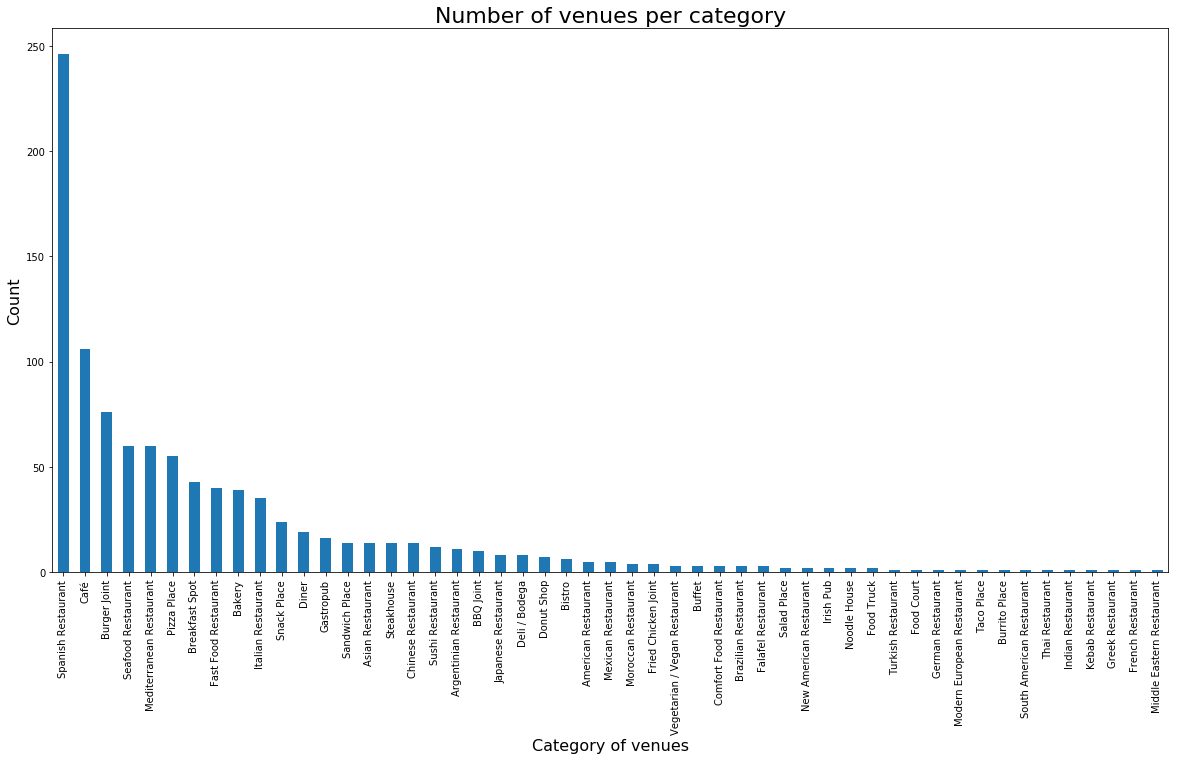

In [21]:
mlg_food_venues.Category.value_counts().plot(kind='bar', figsize=(20,10))
plt.xlabel('Category of venues', fontsize= 16)
plt.ylabel('Count', fontsize = 16)
plt.title('Number of venues per category', fontsize=22)
plt.show()

As we can see, Spanish Restaurant are the most common by far, followed by Cafés and Burger Joints.

Let's continue by creating dummies for the dataset.

In [22]:
malaga_onehot = pd.get_dummies(mlg_food_venues[['Category']], prefix="", prefix_sep="")

malaga_onehot['Neighb'] = mlg_food_venues['Neighb'] 

fixed_columns = [malaga_onehot.columns[-1]] + list(malaga_onehot.columns[:-1])
malaga_onehot = malaga_onehot[fixed_columns]

malaga_onehot.head()

,Neighb,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,...,Seafood Restaurant,Snack Place,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,Cañada de ceuta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,San juan-el albaricocal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,San juan-el albaricocal,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,San juan-el albaricocal,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,San juan-el albaricocal,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


And now, let's group by neighbourhood

In [23]:
mlg_group = malaga_onehot.groupby('Neighb').mean().reset_index()
mlg_group.head()

,Neighb,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,...,Seafood Restaurant,Snack Place,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,26 de febrero,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,503 viviendas,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.250000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,Aeropuerto base aerea,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,...,0.090909,0.0,0.0,0.272727,0.0,0.0,0.0,0.0,0.0,0.0
3,Almudena,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,...,0.083333,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0
4,Amoniaco,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


The following lines import the KMeans function from de Scikit library. We are taking 5 clusters to group our data.

In [24]:
from sklearn.cluster import KMeans

kclusters = 10

mlg_group_clustering = mlg_group.drop('Neighb', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mlg_group_clustering)

kmeans.labels_[0:10]

array([1, 8, 0, 0, 9, 0, 0, 0, 7, 7], dtype=int32)

Now, let's create a function that retrieves the most common venues in a neighbourhood...

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Neighb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighb'] = mlg_group['Neighb']

for ind in np.arange(mlg_group.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mlg_group.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,26 de febrero,Diner,Vegetarian / Vegan Restaurant,Chinese Restaurant,Fried Chicken Joint,French Restaurant
1,503 viviendas,Fast Food Restaurant,Mediterranean Restaurant,Seafood Restaurant,Burger Joint,Vegetarian / Vegan Restaurant
2,Aeropuerto base aerea,Spanish Restaurant,Fast Food Restaurant,Café,Bakery,Seafood Restaurant
3,Almudena,Spanish Restaurant,Burger Joint,Bakery,Seafood Restaurant,Pizza Place
4,Amoniaco,Bakery,Vegetarian / Vegan Restaurant,Chinese Restaurant,Fried Chicken Joint,French Restaurant


... and insert the results of the clustering process in the new dataframe.

In [27]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [28]:
mlg_merged=neighbourhood.set_index("Name").join(neighborhoods_venues_sorted.set_index("Neighb")).reset_index().rename({"index":"Neighb"},axis=1).dropna()
mlg_merged["Cluster Labels"]=mlg_merged["Cluster Labels"].map(lambda x: int(x))
mlg_merged.head()

,Neighb,Latitude,Longitude,Num_neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,26 de febrero,36.741873,-4.428834,106,1,Diner,Vegetarian / Vegan Restaurant,Chinese Restaurant,Fried Chicken Joint,French Restaurant
3,503 viviendas,36.739066,-4.428161,378,8,Fast Food Restaurant,Mediterranean Restaurant,Seafood Restaurant,Burger Joint,Vegetarian / Vegan Restaurant
5,Aeropuerto base aerea,36.678051,-4.495256,331,0,Spanish Restaurant,Fast Food Restaurant,Café,Bakery,Seafood Restaurant
8,Almudena,36.686885,-4.450298,198,0,Spanish Restaurant,Burger Joint,Bakery,Seafood Restaurant,Pizza Place
10,Amoniaco,36.710051,-4.502312,225,9,Bakery,Vegetarian / Vegan Restaurant,Chinese Restaurant,Fried Chicken Joint,French Restaurant


Once we have obtained the different clusters, let's plot it on a map.

In [29]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

latitude, longitude = (36.717448, -4.431831)

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mlg_merged['Latitude'], mlg_merged['Longitude'], mlg_merged["Neighb"], mlg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Part II

Once we have studied the most common venues and their location, we are going to analyze the prefered venues by the customers, to see if there is a coincidence between both datasets.

In order to do that, let's retrieve the following data from each venue:

* Count of tips
* Rating
* Count of likes
* Count of photos

The goal is to get the prefered venue by the customers, taking account of the data we usually check when we are looking for a place to eat in apps like Foursquare or Tripadvisor. 

High ratings do not mean high popularity, but if a venue has a high count of the parameters listed above, it may mean that the customer experience is positive.

In [30]:
def reviews(names, latitudes, longitudes, idRest, client_id, client_secret):
    version='20180605'
    venues_list=[]
    for name, lat, lng, venue_id in zip(names, latitudes, longitudes, idRest):
        print([name, venue_id])
        
        url = 'https://api.foursquare.com/v2/venues/{}?&v={}&client_id={}&client_secret={}'.format(
                    venue_id,
                    version,
                    client_id,
                    client_secret)
        try:
            results = requests.get(url).json()["response"]['venue']

            venues_list.append([(
                                name, 
                                lat, 
                                lng,
                                results['id'],
                                results['name'], 
                                results['location']['lat'], 
                                results['location']['lng'],
                                results['stats']['tipCount'],
                                results['rating'],
                                results['likes']['count'],
                                results["photos"]['count'],
                                results['categories'][0]['name'])])
        except:
            pass

        rated_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        rated_venues.columns = ['Neighb', 
                              'Latitude', 
                              'Longitude',
                              'IdVenue',
                              'Venue', 
                              'Lat_venue', 
                              'Long_venue',
                              'Tip_count',
                              'Rating',
                              'Likes',
                              'Photos_count',
                              'Category']


    return(rated_venues)

Since the Foursquare API has some limitations to the Personal account (500 premium calls/day), let's split our data in 2 datasets, so we can use 2 client id's and secrets to retrieve the data needed.

In [25]:
mlg_rest1=mlg_food_venues[:500]
mlg_rest2=mlg_food_venues[500:]

The data obtained from the function is saved to two different .csv files which have been concatenated and saved to my Github repository in order to preserve the secrecy of the API keys.

Let's group again the similar values.

In [104]:
mlg_ratings.replace({'Category':r'^Tapas'},{'Category': 'Spanish'}, regex=True, inplace=True)
mlg_ratings.replace({'Category': r'^Paella'},{'Category': 'Spanish'}, regex=True, inplace=True)

To get the best rated venues taking account of all the numerical parameters that we can get from the 'details' endpoint, we are going to divide every column by the maximum value, and get the mean of every row. The outcome is a score from 0 to 1 that will give us a hint about the popularity of a venue.

In [105]:
mlg_ratings.Tip_count = mlg_ratings.Tip_count.divide(mlg_ratings.Tip_count.max())
mlg_ratings.Rating = mlg_ratings.Rating.divide(mlg_ratings.Rating.max())
mlg_ratings.Likes = mlg_ratings.Likes.divide(mlg_ratings.Likes.max())
mlg_ratings.Photos_count = mlg_ratings.Photos_count.divide(mlg_ratings.Photos_count.max())

In [106]:
mlg_ratings['Score']=(mlg_ratings.Tip_count+mlg_ratings.Rating+mlg_ratings.Likes+mlg_ratings.Photos_count)/4

Let's keep only relevant data and sort the values by score

In [107]:
mlg_ratings.drop(['Unnamed: 0', 'Latitude', 'Longitude', 'IdVenue', 'Lat_venue', 'Long_venue'], axis=1, inplace=True)

According to the score we have created, now we are going to group the dataset values by Category and get their statistics:

In [159]:
mlg_ratings_stats['Mean']=mlg_ratings.groupby('Category')[['Score']].mean()
mlg_ratings_stats['Std']=mlg_ratings.groupby('Category')[['Score']].std()
mlg_ratings_stats['Median']=mlg_ratings.groupby('Category')[['Score']].median()
mlg_ratings_stats['Count']=mlg_ratings.groupby('Category').size()

#replace all NaN values by 0
mlg_ratings_stats.fillna(0, inplace=True)

To avoid a bias, let's take away the categories with only 1 venue in this dataset. The bias would be caused by a lack of samples, which will give us a null standard deviation. The best results would always be the categories with only 1 venue.

After that, we will create a column called 'Diff', that computes the difference between the mean and the standard deviation. This will return the most solid categories, i.e. the ones with the greatest mean scores and the lowest standar deviations.

In [179]:
mlg_ratings_stats=mlg_ratings_stats[mlg_ratings_stats.Count>1].sort_values('Mean', ascending=False)
mlg_ratings_stats['Diff']=mlg_ratings_stats.Mean-mlg_ratings_stats.Std

# 4. Results

## Part I

To show the results of the first part of this project, we are going to create a bar plot that shows the number of venues in each cluster.

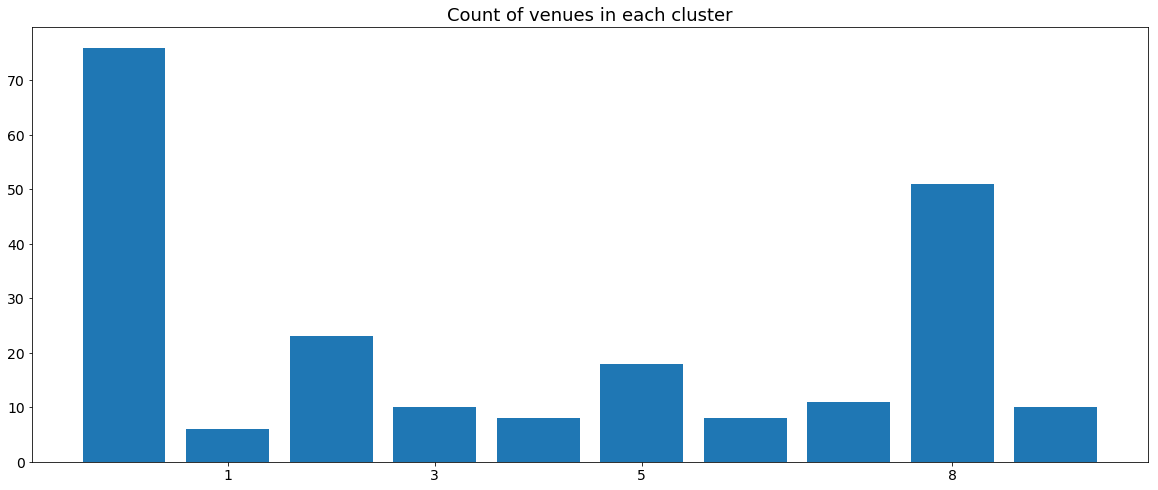

In [31]:

plt.figure(figsize=(20,8))


cluster_count = mlg_merged.groupby("Cluster Labels").count()[["Neighb"]].rename(columns={"Neighb":"Count"})

plt.xticks(mlg_merged.index, fontsize=14)
plt.yticks(fontsize=14)
plt.bar(cluster_count.index, cluster_count["Count"])
plt.title("Count of venues in each cluster", fontsize=18)
plt.show()

In [32]:
print('The most populated cluster is cluster', cluster_count.index[cluster_count["Count"]==cluster_count["Count"].max()][0])

The most populated cluster is cluster 0


In [33]:
mlg_merged[mlg_merged["Cluster Labels"]==cluster_count.index[cluster_count["Count"]==cluster_count["Count"].max()][0]].groupby('1st Most Common Venue').count().sort_values("Neighb", ascending=False)[["Neighb"]].rename(columns={"Neighb":"Frequency"}).head()

,Frequency
1st Most Common Venue,
Spanish Restaurant,42
Asian Restaurant,5
Café,5
Bakery,4
Burger Joint,4


As we can see, the most common venues of the biggest cluster are **Spanish restaurants**. 

Let's check if the sample is similar to the whole population of the dataset

In [226]:
mlg_food_venues.groupby("Category").count()[["Neighb"]].rename(columns={'Neighb':'Frequency'}).sort_values(by='Frequency', ascending=False).head()

,Frequency
Category,
Spanish Restaurant,246
Café,106
Burger Joint,76
Mediterranean Restaurant,60
Seafood Restaurant,60


3 out of 5 categories are present in both the sample and the population, so it's safe to say that the cluster is a good representation of the whole dataset.

## Part II

The table shown below represents the statistics obtained from the computing process described in Part II of the Methodology section.

The 'Diff' column retrieves the difference between the mean and the standard deviation of each category or neighbourhood. The smallest values mean that the parameters computed (rating, tips count, photos count, likes count) are consistent within the sample.

In [181]:
mlg_ratings_stats.sort_values('Diff', ascending=False).head()

,Mean,Std,Median,Count,Diff
Category,,,,,
Vegetarian / Vegan Restaurant,0.234583,0.011946,0.235298,3,0.222637
BBQ Joint,0.220684,0.022997,0.220684,2,0.197687
New American Restaurant,0.204292,0.010904,0.204292,2,0.193388
Gastropub,0.211376,0.018010,0.212310,13,0.193366
Deli / Bodega,0.293389,0.105618,0.293389,2,0.187771


# 5. Conclusions

These are a few conclusions that we can extract from the analysis:

1. The clusters are a good representation of the whole studied population.
2. The most common venues, which consist of Spanish (including Tapas and Paella), Mediterranean and Seafood restaurants among others, answer to the fact that Málaga attracts a great amount of tourists that want to try this kind of food.
3. So, following the reasoning of point 2, the neighbourhoods that belong to the most populated cluster are among the most visited places by tourists.
3. However, according to the selected methodology in Part II, the most common venues have no correlation with the prefered ones by the customers. This can be explained by the fact that less common venues are more attractive to people, since there is no variety.

That said, a possible solution to the business problem is to open one a venue from the results of Part II in one of the neighbourhoods of the most populated cluster.